<a href="https://colab.research.google.com/github/zubao-fitti/processamento_imagens/blob/master/Projeto_Detec%C3%A7%C3%A3o_de_N%C3%BAmeros_Residenciais_Mateus_Fittipaldi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/zubao-fitti/processamento_imagens.git

fatal: destination path 'processamento_imagens' already exists and is not an empty directory.


In [ ]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow  #usar o comando imshow diretamente no colab

# **Pré-processamento**

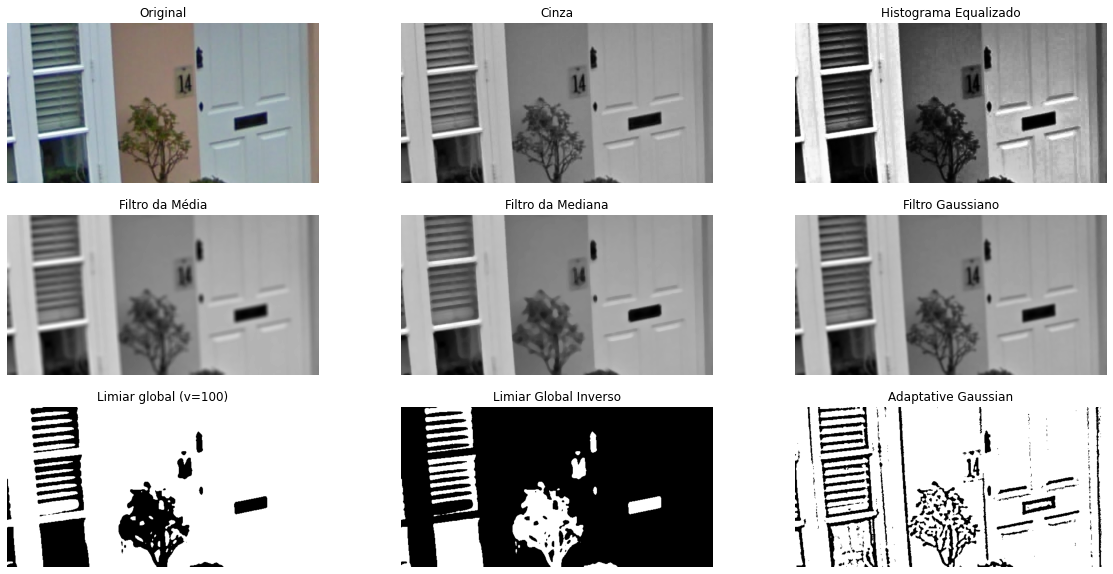

In [ ]:
# 50 imagens de 1.png a 50.png
test = cv2.imread('processamento_imagens/Banco de Imagens/47.png')

# conversão para tons de cinza
testGray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
# equalização do histograma
testEq = cv2.equalizeHist(testGray)

# suavização da imagem para evitar a detecção do fundo
# tamanho da mascara
kmask = 9
# mascara do filtro da média
kernel = np.ones((kmask,kmask),np.float32)/(kmask*kmask)
# filtro da média
testMeanBlur = cv2.filter2D(testGray,-1,kernel)
# filtro da mediana
testMedianBlur = cv2.medianBlur(testGray,kmask)
# filtro gaussiano
testGaussianBlur = cv2.GaussianBlur(testGray, (kmask,kmask), 0)

# binarização a partir do resultado do filtro gaussiano (melhor resultado)
ret,testBin = cv2.threshold(testGaussianBlur,100,255,cv2.THRESH_BINARY)
ret,testBinInv = cv2.threshold(testGaussianBlur,100,255,cv2.THRESH_BINARY_INV)
testBinGaussian = cv2.adaptiveThreshold(testGaussianBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

# exibição dos resultados do pré-processamento
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(testGray, cmap='gray')
ax[1].set_title('Cinza')
ax[1].set_axis_off()

ax[2].imshow(testEq, cmap='gray')
ax[2].set_title('Histograma Equalizado')
ax[2].set_axis_off()

ax[3].imshow(testMeanBlur, cmap='gray')
ax[3].set_title('Filtro da Média')
ax[3].set_axis_off()

ax[4].imshow(testMedianBlur, cmap='gray')
ax[4].set_title('Filtro da Mediana')
ax[4].set_axis_off()

ax[5].imshow(testGaussianBlur, cmap='gray')
ax[5].set_title('Filtro Gaussiano')
ax[5].set_axis_off()

ax[6].imshow(testBin, cmap='gray')
ax[6].set_title('Limiar global (v=100)')
ax[6].set_axis_off()

ax[7].imshow(testBinInv, cmap='gray')
ax[7].set_title('Limiar Global Inverso')
ax[7].set_axis_off()

ax[8].imshow(testBinGaussian, cmap='gray')
ax[8].set_title('Adaptative Gaussian')
ax[8].set_axis_off()

#Segmentação/Detecção de Bordas

##Função Watershed

In [ ]:
def myWatershed(src, binImg):
  originalImg = src.copy()
  binImg = 255 - binImg
  
  kernel = np.ones((3,3),np.uint8)
  # sure background area
  sure_bg = cv2.dilate(binImg,kernel)

  # Finding sure foreground area
  dist_transform = cv2.distanceTransform(binImg,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)

  # Marker labelling
  ret, markers = cv2.connectedComponents(sure_fg)
  # Add one to all labels so that sure background is not 0, but 1
  markers = markers+1
  # Now, mark the region of unknown with zero
  markers[unknown==255] = 0

  markers = cv2.watershed(originalImg,markers)
  originalImg[markers == -1] = [0,255,0]

  return originalImg

##Função Kmeans

In [ ]:
def myKmeans(src, K):
  # coversão da imagem para ser usada no kmeans
  Z = src.reshape((-1,3))
  Z = np.float32(Z)
  
  # definição do criterio de parada e aplicacao do kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

  # coversão de volta para mostrar a imagem
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((src.shape))

  return res2

##Aplicação da Detecção de Bordas

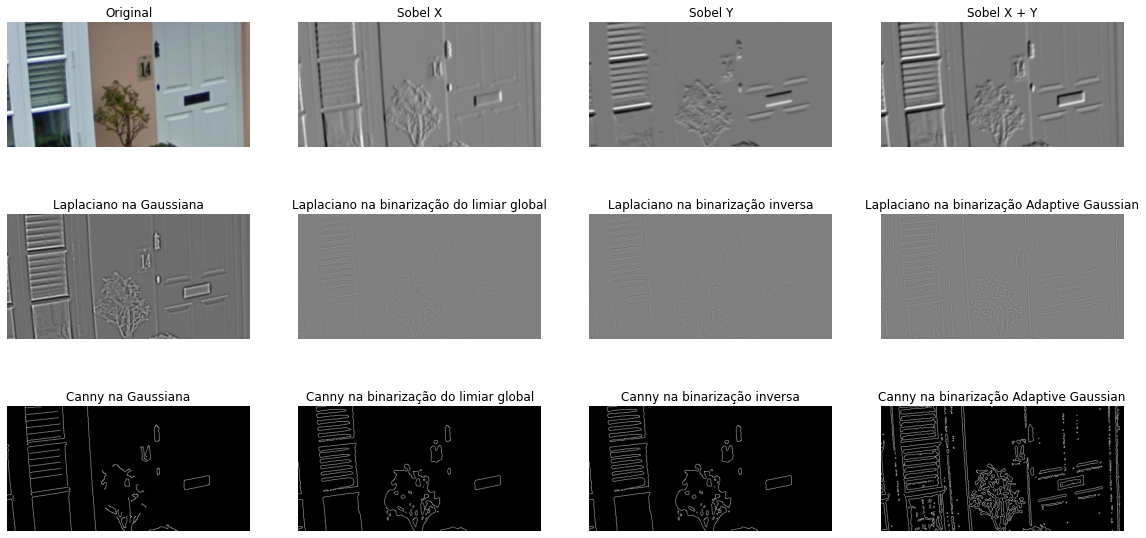

In [ ]:
# sobel no eixo X aplicado na Gaussiana
testSobelx = cv2.Sobel(testGaussianBlur,cv2.CV_64F,1,0,ksize=5)
# sobel no eixo Y aplicado na Gaussiana
testSobely = cv2.Sobel(testGaussianBlur,cv2.CV_64F,0,1,ksize=5)
# solbe x + sobel y
testSobelxy = testSobelx + testSobely

# laplaciano aplicado na Gaussiana
testLaplacianGaussian = cv2.Laplacian(testGaussianBlur,cv2.CV_64F)
# laplaciano aplicado na binarização do limiar global
testLaplacianBin = cv2.Laplacian(testBin,cv2.CV_64F)
# laplaciano aplicado na binarização do limiar global inverso
testLaplacianBinInv = cv2.Laplacian(testBinInv,cv2.CV_64F)
# laplaciano aplicado na binarização Adaptive Gaussian
testLaplacianBinGaussian = cv2.Laplacian(testBinGaussian,cv2.CV_64F)

# detecção de bordas usando o algoritmo de Canny
th1, th2 = 50, 120 # thresholds
# Canny aplicado na gaussiana
testCannyGaussian = cv2.Canny(testGaussianBlur, th1, th2)
# Canny aplicado na binarização do limiar global
testCannyBin = cv2.Canny(testBin, th1, th2)
# Canny aplicado na binzarização do limiar gloval inverso
testCannyBinInv = cv2.Canny(testBinInv, th1, th2)
# Canny aplicado na binarização Adaptive Gaussian
testCannyBinGaussian = cv2.Canny(testBinGaussian, th1, th2)

fig, axes = plt.subplots(3, 4, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(testSobelx, cmap='gray')
ax[1].set_title('Sobel X')
ax[1].set_axis_off()

ax[2].imshow(testSobely, cmap='gray')
ax[2].set_title('Sobel Y')
ax[2].set_axis_off()

ax[3].imshow(testSobelxy, cmap='gray')
ax[3].set_title('Sobel X + Y')
ax[3].set_axis_off()

ax[4].imshow(testLaplacianGaussian, cmap='gray')
ax[4].set_title('Laplaciano na Gaussiana')
ax[4].set_axis_off()

ax[5].imshow(testLaplacianBin, cmap='gray')
ax[5].set_title('Laplaciano na binarização do limiar global')
ax[5].set_axis_off()

ax[6].imshow(testLaplacianBinInv, cmap='gray')
ax[6].set_title('Laplaciano na binarização inversa')
ax[6].set_axis_off()

ax[7].imshow(testLaplacianBinGaussian, cmap='gray')
ax[7].set_title('Laplaciano na binarização Adaptive Gaussian')
ax[7].set_axis_off()

ax[8].imshow(testCannyGaussian, cmap='gray')
ax[8].set_title('Canny na Gaussiana')
ax[8].set_axis_off()

ax[9].imshow(testCannyBin, cmap='gray')
ax[9].set_title('Canny na binarização do limiar global')
ax[9].set_axis_off()

ax[10].imshow(testCannyBinInv, cmap='gray')
ax[10].set_title('Canny na binarização inversa')
ax[10].set_axis_off()

ax[11].imshow(testCannyBinGaussian, cmap='gray')
ax[11].set_title('Canny na binarização Adaptive Gaussian')
ax[11].set_axis_off()

##Aplicação da Segmentação

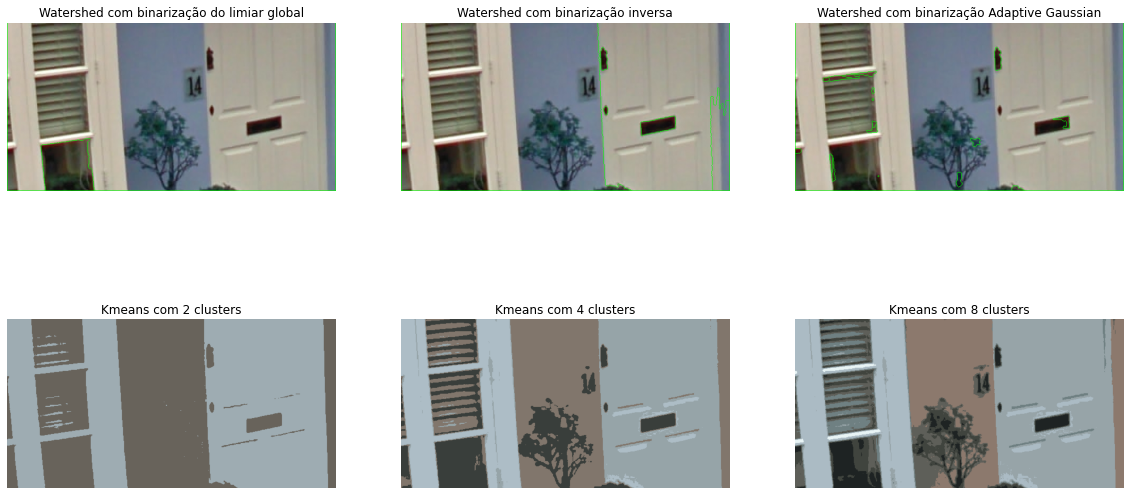

In [ ]:
# segmentação Watershed
# watershed com binarização do limiar global
testWatershedBin = myWatershed(test, testBin)
# watershed com binarizalçao do limiar global inverso
testWatershedBinInv = myWatershed(test, testBinInv)
# watershed com binarização Adaptive Gaussian
testWatershedBinGaussian = myWatershed(test, testBinGaussian)

# segmentação Kmeans
# 2 clusters
testKmeans2 = myKmeans(test, 2)
# 4 clusters
testKmeans4 = myKmeans(test, 4)
# 8 clusters
testKmeans8 = myKmeans(test, 8)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(testWatershedBin, cmap='gray')
ax[0].set_title('Watershed com binarização do limiar global')
ax[0].set_axis_off()

ax[1].imshow(testWatershedBinInv, cmap='gray')
ax[1].set_title('Watershed com binarização inversa')
ax[1].set_axis_off()

ax[2].imshow(testWatershedBinGaussian, cmap='gray')
ax[2].set_title('Watershed com binarização Adaptive Gaussian')
ax[2].set_axis_off()

ax[3].imshow(cv2.cvtColor(testKmeans2, cv2.COLOR_BGR2RGB))
ax[3].set_title('Kmeans com 2 clusters')
ax[3].set_axis_off()

ax[4].imshow(cv2.cvtColor(testKmeans4, cv2.COLOR_BGR2RGB))
ax[4].set_title('Kmeans com 4 clusters')
ax[4].set_axis_off()

ax[5].imshow(cv2.cvtColor(testKmeans8, cv2.COLOR_BGR2RGB))
ax[5].set_title('Kmeans com 8 clusters')
ax[5].set_axis_off()